# Direct Regression (Medium)

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

This task involves a dataset $\left\lbrace (x_1,y_1) \dots, (x_L,y_L) \right\rbrace \subseteq \mathbb{R}^N \times \mathbb{R}$ of varying size $L$, where $y_i = f_\theta(x_i)$ for some randomly initialized tanh network $f_\theta$ acting as the ground truth function.
To keep things relatively simple, the tanh network has a single hidden layer of size 2.

The model must use this data to predict the $f_\theta(x)$ of an unseen point $x$.

The task is evaluated using R-squared of the predictions.

In [ ]:
from torch import Tensor

def get_r_squared(
        target: Tensor,
        mean: Tensor,
        prediction: Tensor,
) -> float:
    B = target.shape[:-1]
    L = target.shape[-1]
    assert prediction.shape == (*B, L)
    assert mean.shape == B

    tss = (target - mean.unsqueeze(dim=-1)).square().sum(dim=-1)
    rss = (target - prediction).square().sum(dim=-1)
    assert tss.shape == rss.shape == B

    r_squared = torch.where(tss > 0.0, 1.0 - (rss / tss), 0.0)
    assert r_squared.shape == B
    return float(r_squared.mean())

## Data

During training, the data generation process is as follows:

- sample a length $L$ uniformly from $1$ to $L_\mathrm{max}$ inclusive
- sample a mean $\mu \in \mathbb{R}^N \sim \mathcal{N}(0,I)$
- sample $x_1, \dots, x_L \sim \mathcal{N}(\mu,I)$
- sample weights $\theta$ of a tanh network $f_\theta$
- for $1 \leq i \leq L$, compute $y_i = f_\theta(x_i)$

For these experiments we use $L_\mathrm{max} = 100$.

During evaluation, we evalute $1000$ times for each value of $L$ from $2$ to $2 L_\mathrm{max}$ and plot the r_squared curve.

In [3]:
class BatchReLUNetwork:
    def __init__(
            self,
            *,
            batch_size: int,
            input_dim: int,
            hidden_dim: int = 2,
            device: torch.device = device,
    ):
        super().__init__()

        B = batch_size
        I = input_dim
        H = hidden_dim

        self.batch_size = B
        self.input_dim = I
        self.hidden_dim = H
        self.weight_1 = torch.randn((B, I, H), device=device)
        self.bias_1 = torch.randn((B, 1, H), device=device)
        self.weight_2 = torch.randn((B, H, 1), device=device)
        self.bias_2 = torch.randn((B, 1), device=device)

    def __call__(self, x: Tensor) -> Tensor:
        B, L, I = x.shape
        assert B == self.batch_size
        assert I == self.input_dim
        H = self.hidden_dim

        embeds = torch.bmm(x, self.weight_1)
        assert embeds.shape == (B, L, H)
        embeds = embeds + self.bias_1
        assert embeds.shape == (B, L, H)
        embeds = torch.tanh(embeds)

        y = torch.bmm(embeds, self.weight_2)
        assert y.shape == (B, L, 1)
        y = y.squeeze(dim=-1)
        assert y.shape == (B, L)
        y = y + self.bias_2
        assert y.shape == (B, L)

        return y


def get_uniform_batch(
        *,
        length: int,
        input_dim: int,
        batch_size: int,
        next_count: int,
        rng: torch.Generator,
        device: torch.device = device,
) -> tuple[Tensor, Tensor, Tensor, Tensor]:
    B = batch_size
    L = length
    N = input_dim
    C = next_count

    f = BatchReLUNetwork(
        batch_size=B,
        input_dim=N,
        device=device,
    )

    mean = torch.randn((B, N), generator=rng, device=device)
    x = torch.randn((B, L+C, N), generator=rng, device=device)
    x = x + mean.unsqueeze(dim=-2)

    y = f(x)
    return x[:,:-C,:], y[:,:-C], x[:,-C:,:], y[:,-C:]

L_max = 100

def get_mixed_batch(
        *,
        input_dim: int,
        batch_size: int,
        next_count: int,
        max_length: int = L_max,
        rng: torch.Generator,
        device: torch.device = device,
) -> tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
    B = batch_size
    I = input_dim
    C = next_count

    length = torch.randint(
        low=1,
        high=max_length + 1,
        size=(B,),
        generator=rng,
        device=device,
    )
    L = int(length.max())

    x, y, next_x, next_y = get_uniform_batch(
        length=L,
        input_dim=I,
        batch_size=B,
        next_count=C,
        rng=rng,
        device=device,
    )
    mask = torch.arange(L, device=device).unsqueeze(dim=0) < length.unsqueeze(dim=-1)
    return x, y, next_x, next_y, mask

## Model

In [4]:
from typing import Optional

import torch
from torch import nn, Tensor


class DirectRegressionModel(nn.Module):
    def __init__(
            self,
            input_dim: int,
            embed_dim: int,
            num_heads: int,
            num_layers: int,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers

        self.x_ff = nn.Sequential(
            nn.Linear(in_features=input_dim, out_features=embed_dim),
            nn.GELU(),
            nn.Linear(in_features=embed_dim, out_features=embed_dim),
            nn.GELU(),
        )
        self.y_ff = nn.Sequential(
            nn.Linear(in_features=1, out_features=embed_dim),
            nn.GELU(),
            nn.Linear(in_features=embed_dim, out_features=embed_dim),
            nn.GELU(),
        )
        if num_layers > 0:
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                activation="gelu",
                dropout=0.0,
                dim_feedforward=(embed_dim*4),
                norm_first=True,
                batch_first=True,
            )
            self.transformer = nn.TransformerEncoder(layer, num_layers=num_layers)
        self.output_ff = nn.Linear(in_features=embed_dim, out_features=1)

    def forward(
            self,
            *,
            x: Tensor,
            y: Tensor,
            next_x: Tensor,
            next_y: Optional[Tensor] = None,
            mask: Optional[Tensor] = None,
    ) -> tuple[Tensor, Tensor]:
        B, L, I = x.shape
        assert I == self.input_dim
        assert y.shape == (B, L)
        assert next_x.shape == (B, I)
        if next_y is not None:
            assert next_y.shape == (B,)

        E = self.embed_dim

        x_embeds = self.x_ff(torch.cat((x, next_x.unsqueeze(dim=-2)), dim=-2))
        assert isinstance(x_embeds, Tensor)
        assert x_embeds.shape == (B, L+1, E)

        y_embeds = self.y_ff(y.unsqueeze(dim=-1))
        assert isinstance(y_embeds, Tensor)
        assert y_embeds.shape == (B, L, E)
        y_embeds = torch.cat((y_embeds, torch.zeros((B, 1, E), device=x.device)), dim=-2)
        assert y_embeds.shape == (B, L+1, E)

        embeds = x_embeds + y_embeds

        if self.num_layers > 0:
            if mask is None:
                transformer_mask = None
            else:
                assert mask.shape == (B, L)
                transformer_mask = torch.cat((
                    ~mask,
                    torch.zeros((B, 1), dtype=torch.bool, device=mask.device)
                ), dim=-1)
                assert transformer_mask.shape == (B, L+1)
            embeds = self.transformer(embeds, src_key_padding_mask=transformer_mask)
            assert isinstance(embeds, Tensor)
            assert embeds.shape == (B, L+1, E)

        y_hat = self.output_ff(embeds[:,-1,:])
        assert isinstance(y_hat, Tensor)
        assert y_hat.shape == (B, 1)
        y_hat = y_hat.squeeze(dim=-1)

        if next_y is None:
            loss = torch.zeros((), device=x.device)
        else:
            assert y_hat.shape == (B,)
            error = next_y - y_hat
            loss = error.square().mean()

        return y_hat, loss


## Experiment

In [5]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

lengths = list(range(1, 2*L_max+1))

train_steps_per_epoch = 1000
train_batch_size = 100
eval_batch_size = 100
epochs_without_improvement_to_stop = 10

def experiment(
    *,
    input_dim: int,
    embed_dim: int,
    num_heads: int,
    num_layers: int,
    seed: int = 0,
) -> float:
    torch.manual_seed(seed)

    model = DirectRegressionModel(
        input_dim=input_dim,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_layers=num_layers,
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())

    mean_loss_acc: list[float] = []
    r_squared_accs: list[list[float]] = []
    mean_r_squared_acc: list[float] = []
    best_epoch: int = 0
    best_mean_r_squared: float = 0.0

    train_rng = torch.Generator(device=device).manual_seed(seed)

    epoch = 0
    while True:
        if epoch - best_epoch > epochs_without_improvement_to_stop:
            break

        total_loss = 0.0
        if epoch > 0:
            model.train()
            for i in range(train_steps_per_epoch):
                x, y, next_x, next_y, mask = get_mixed_batch(
                    input_dim=input_dim,
                    batch_size=train_batch_size,
                    next_count=1,
                    rng=train_rng,
                )
                _, loss = model(
                    x=x,
                    y=y,
                    next_x=next_x.squeeze(dim=-2),
                    next_y=next_y.squeeze(dim=-1),
                    mask=mask,
                )
                assert isinstance(loss, Tensor)

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                total_loss += float(loss)
        mean_loss = total_loss / train_steps_per_epoch
        mean_loss_acc.append(mean_loss)

        eval_rng = torch.Generator(device=device).manual_seed(0)
        with torch.no_grad():
            r_squared_acc: list[float] = []
            model.eval()
            for L in lengths:
                x, y, next_x, next_y = get_uniform_batch(
                    length=L,
                    input_dim=input_dim,
                    batch_size=eval_batch_size,
                    next_count=10,
                    rng=eval_rng,
                )
                predictions_acc: list[Tensor] = []
                for i in range(10):
                    y_hat, _ = model(
                        x=x,
                        y=y,
                        next_x=next_x[:,i,:],
                    )
                    assert isinstance(y_hat, Tensor)
                    predictions_acc.append(y_hat)
                prediction = torch.stack(predictions_acc, dim=-1)
                target = next_y
                mean = y.mean(dim=-1)
                r_squared = get_r_squared(
                    target=target,
                    mean=mean,
                    prediction=prediction,
                )
                r_squared_acc.append(r_squared)
            r_squared_accs.append(r_squared_acc)
            mean_r_squared = sum(r_squared_acc) / len(r_squared_acc)
            mean_r_squared_acc.append(mean_r_squared)

            if mean_r_squared > best_mean_r_squared:
                best_mean_r_squared = mean_r_squared
                best_epoch = epoch

        plt.figure(figsize=(8.0, 6.0))
        e = 1
        while e <= epoch:
            plt.plot(lengths, r_squared_accs[e], label=f"Epoch {e}", alpha=e/epoch)
            e *= 2
        plt.plot(lengths, r_squared_accs[best_epoch], label=f"Best Epoch ({best_epoch})")
        plt.xlabel("sequence length")
        plt.xlim(1, 2*L_max)
        plt.xscale("log")
        plt.ylabel("R\u00b2")
        plt.ylim(bottom=-1.0, top=1.0)
        plt.legend()
        clear_output(wait=True)
        plt.show()
        for e, (ml, mp) in enumerate(zip(mean_loss_acc, mean_r_squared_acc)):
            if e == 0:
                continue
            print(
                f"Epoch {e:03d}: mean loss = {ml:.3f} | mean R\u00b2 = {mp:.3f}"
                + (" (*)" if best_epoch == e else "")
            )

        epoch += 1

    return best_mean_r_squared

**TODO**: ablations

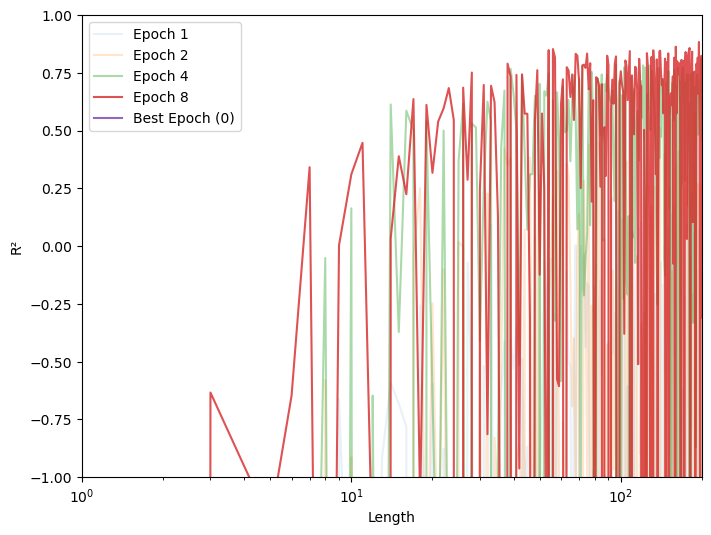

Epoch 001: mean loss = 0.684 | mean R² = -150.049
Epoch 002: mean loss = 0.389 | mean R² = -393.433
Epoch 003: mean loss = 0.227 | mean R² = -256.567
Epoch 004: mean loss = 0.184 | mean R² = -9.507
Epoch 005: mean loss = 0.170 | mean R² = -323.118
Epoch 006: mean loss = 0.162 | mean R² = -2651.373
Epoch 007: mean loss = 0.146 | mean R² = -86.390
Epoch 008: mean loss = 0.142 | mean R² = -9.386
Epoch 009: mean loss = 0.138 | mean R² = -61.821
Epoch 010: mean loss = 0.131 | mean R² = -223.310


0.0

In [6]:
experiment(
    input_dim=4,
    embed_dim=16,
    num_heads=4,
    num_layers=4,
)